# ShallowNeuralNetwork(Tensorflow)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets

### 1 Load Data

这里我们使用sklearn中的iris数据集.

In [2]:
def loadData_iris():
    """
    Returns:
    --------
        X:have two dimensions (sepal length and width).
        Y:labels.
    """
    iris = datasets.load_iris()
    X = iris.data[:100, :2]
    Y = iris.target[:100]
    return X,Y

In [3]:
X,y = loadData_iris()
print('X shape is:',X.shape)
print('y shape is:',y.shape)

X shape is: (100, 2)
y shape is: (100,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

同样和Application中一样,我们将数据转置.

In [5]:
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

X_train shape: (2, 80)
X_test shape: (2, 20)
y_train shape: (1, 80)
y_test shape: (1, 20)


### 2 Initialization Parameters

我们使用```tf.Variable```创建变量,其中$W$使用随机的标准正态分布数据,$b$初始化为0,并设置随机数种子```seed=1```

In [6]:
def initial_parameters(layers):
    """
    parameters:
    ----------
        layers: L layers dim.
    Return:
    ------
        parameters: cache weights and bias.
    """
    L = len(layers)
    parameters = {}
    for l in range(1,L):
        parameters['W'+str(l)] = tf.Variable(tf.random_normal([layers[l],layers[l-1]],seed=1))
        parameters['b'+str(l)] = tf.Variable(tf.zeros(shape=(layers[l],1)))
    return parameters

In [7]:
layers = [X_train.shape[0],4,1]
parameters = initial_parameters(layers)
print('W1:',parameters['W1'].shape)
print('b1:',parameters['b1'].shape)
print('W2:',parameters['W2'].shape)
print('b2:',parameters['b2'].shape)

Instructions for updating:
Colocations handled automatically by placer.
W1: (4, 2)
b1: (4, 1)
W2: (1, 4)
b2: (1, 1)


### 3 Build Model

(1) 需要先创建placeholder,其中样本数量我们指定为None,是因为有batch size的存在.

```python
X = tf.placeholder(tf.float32,shape=[n,None])
y = tf.placeholder(tf.float32,shape=[1,None])```

(2) 创建网络hidden layers的形状.

```python
layers = [n,4,1]```

这里总共有两层,第一层的节点为4,输出层的节点为1.

(3) 初始化参数

```python
parameters = initial_parameters(layers)```

(4) forward propagation

```python
Z1 = tf.add(tf.matmul(W1,X),b1)
A1 = tf.nn.relu(Z1)
Z2 = tf.add(tf.matmul(W2,A1),b2)```

(6) compute loss,set optimizer and update parameters

```python
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z2,labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha).minimize(cost)```


(7) start run tensor

**Ps:**

batch size:将在后面阐述

In [8]:
def Model(data,labels,Iter,alpha,is_print=False):
    """
    Build Tensor model
    
    Parameters:
    ----------
        data: training data set
        labels: training labels
        Iter: iterative
        alpha: learning rate
        is_print: print loss value
    
    Return:
    ------
        parameters: have best weights and bias.
    
    """
    
    # create placeholder
    n,m = data.shape
    X = tf.placeholder(tf.float32,shape=[n,None]) # None: batch size
    y = tf.placeholder(tf.float32,shape=[1,None])
    
    # create network structure
    layers = [n,4,1]
    
    # initialization weights and bias
    parameters = initial_parameters(layers)
    
    ####### forward ##########
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    ####### end #############
    
    # compute cost and optimizer
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z2,labels=y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha).minimize(cost) # target:minimize cost.
   
    init = tf.global_variables_initializer()
    
    # star run tensor
    with tf.Session() as sess:
        sess.run(init)
        costs = []
        for iter_ in range(Iter):
            _,loss = sess.run([optimizer,cost],feed_dict={X:data,y:labels})
            
            if iter_ % 1000 == 0 and is_print:
                print('After Iteration: {} loss: {}'.format(iter_,loss))
            if iter_ % 10 == 0:
                costs.append(loss)
                
        
        # get best weights and bias
        parameters['W1'] = sess.run(W1)
        parameters['b1'] = sess.run(b1)
        parameters['W2'] = sess.run(W2)
        parameters['b2'] = sess.run(b2)
        
        # plot cost 
        plt.plot(costs)
        plt.title('Learning rate: {}'.format(alpha))
        plt.xlabel('Iteration per 100')
        plt.ylabel('loss value')
        plt.show()
        
        return parameters
    
    

After Iteration: 0 loss: 0.5297104120254517
After Iteration: 1000 loss: 0.049854621291160583
After Iteration: 2000 loss: 0.037970226258039474


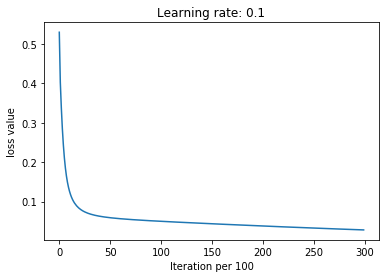

In [9]:
parameters = Model(X_train,y_train,3000,0.1,True)

可以看出loss是下降的一个趋势.

### 4 Predict  and correct rate

下面我们看看训练样本和测试样本的正确率

注意:

在Tensorflow中无法将布尔型直接转换成浮点型,所以我们需要手动转换才能统计正确率

```python
tf.cast```

In [10]:
def predict(data,labels,parameters):
    """
    predict and get data correct rate
    Parameters:
    ----------
        data: data set
        labels: labels
        parameters: best weights and bias
    
    Return:
    ------
        correct_rate: data correct rate.
    """
    n,m = data.shape
    X = tf.placeholder(tf.float32,shape=[n,None])
    y = tf.placeholder(tf.float32,shape=[1,None])
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.sigmoid(Z2)
    
    correct_ = tf.equal(tf.round(A2),y)
    accuracy = tf.reduce_mean(tf.cast(correct_,tf.float32)) # change data type
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        correct_rate = accuracy.eval({X:data,y:labels})
        
        return correct_rate
    

In [11]:
correct = predict(X_test,y_test,parameters)
print('The test data set correct rate:',correct)

The test data set correct rate: 1.0


In [12]:
correct = predict(X_train,y_train,parameters)
print('The train data set correct rate:',correct)

The train data set correct rate: 0.9875


可以看到测试样本的正确率和训练样本的正确率都是很可观的.

### TensorBorder

tensorbord可以将我们的网络可视化出来

[tensorbord](https://www.tensorflow.org/guide/summaries_and_tensorboard?hl=zh_cn)

当更改tensorbord时,需要清空缓存,否则再次载入会在上一次的结果下进行载入.

我们需要使用with tf.name_scope来进行参数命名空间

```python
def variable_summary```

负责计算均值,方差标准差,直方图等..

In [13]:
# 参数概要
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean',mean)   # tf.summary.scalar:记录值，并给予名称
        with tf.name_scope('stddev'):
            stddev = tf.square(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev',stddev)  # 标准差
        tf.summary.scalar('max',tf.reduce_max(var))
        tf.summary.scalar('mins',tf.reduce_min(var))
        tf.summary.histogram('histogram',var)  # 直方图

In [14]:
def Model_tensorbord(data,labels,Iter,alpha,is_print=False):
    """
    Build Tensor model
    
    Parameters:
    ----------
        data: training data set
        labels: training labels
        Iter: iterative
        alpha: learning rate
        is_print: print loss value
    
    Return:
    ------
        parameters: have best weights and bias.
    
    """
    
    # create placeholder
    n,m = data.shape
    with tf.name_scope('input'):
        X = tf.placeholder(tf.float32,shape=[n,None],name='X-input') # None: batch size
        y = tf.placeholder(tf.float32,shape=[1,None],name='y-input')
    
    # create network structure
    with tf.name_scope('inital-parameters'):
        # initialization weights and bias
        with tf.name_scope('layer-1'):
            W1 = tf.Variable(tf.random_normal([4,n],seed=1),name='W1')
            b1 = tf.Variable(tf.zeros(shape=(4,1)),name='b1')
            variable_summary(W1)
            variable_summary(b1)
            
        with tf.name_scope('layer-2'):
            W2 = tf.Variable(tf.random_normal([1,4],seed=1),name='W2')
            b2 = tf.Variable(tf.zeros(shape=(1,1)),name='b2')
            variable_summary(W2)
            variable_summary(b2)
            
    ####### forward ##########        
    with tf.name_scope('forward'):
        with tf.name_scope('forward-1'):
            Z1 = tf.add(tf.matmul(W1,X),b1,name='Z1')
            A1 = tf.nn.relu(Z1,name='A1-relu')
        with tf.name_scope('forward-2'):
            Z2 = tf.add(tf.matmul(W2,A1),b2,name='Z2')
    ####### end #############
    
    # compute cost and optimizer
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z2,labels=y),name='sigmoid_ent')
        tf.summary.scalar('loss',cost)
        
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha,name='GD').minimize(cost) # target:minimize cost.
   
    with tf.name_scope('accuracy'):
        correct_ = tf.equal(tf.round(tf.sigmoid(Z2)),y)
        accuracy = tf.reduce_mean(tf.cast(correct_,tf.float32))
        tf.summary.scalar('accuracy',accuracy)
      
    
    init = tf.global_variables_initializer()
    
    # merge all summary
    merged = tf.summary.merge_all()
    
    # star run tensor
    with tf.Session() as sess:
        sess.run(init)
    
        write = tf.summary.FileWriter('tensor_model',sess.graph)
        for iter_ in range(Iter):
            _,summary,loss = sess.run([optimizer,merged,cost],feed_dict={X:data,y:labels})
            write.add_summary(summary,iter_)  
            if iter_ % 1000 == 0 and is_print:
                print('After Iteration: {} loss: {}'.format(iter_,loss))
             
        

    

In [15]:
Model_tensorbord(X_train,y_train,300,0.1,is_print=True)

After Iteration: 0 loss: 0.5297104120254517


那么会在当前同级文件下产生一个"tensor_model"的文件.

Terminal 进入该文件,使用```tensorboard --logdir=tensor_model```完成Tensorbord运行.

在GoogleChrome中输入地址即可进入可视化界面

![](../picture/12.png)![](../picture/13.png)![](../picture/14.png)